# Detrending data for Pyaneti modelling


This notebook covers how enhance a figure. The start of this notebook is similar to the one from the previous episode entitle (Introduction to lightkurve - downloading and plotting data

by Nora Eisner

In [4]:
%matplotlib notebook

#imports
import os
import numpy as np
import pandas as pd
import lightkurve as lk 
import astropy.io.fits as pf
import matplotlib.pyplot as plt


In [7]:
# add the path to where you want to save the data
# at the location of that path you need to manually create a folder that has the name of the TIC ID. e.g. '55525572'

#e.g. on my computer the path is
outfile = '/Users/Nora/planethunters/code/pyaneti/inpy/'

In [34]:
def detrend_pyaneti(tic, transit_time_list, alltime, allflux, allflux_err, lim_window, lim, poly_n, save = True):
    
    
    combined_corr_time = []
    combined_corr_flux = []
    combined_corr_err  = []
    
    for transit_time in transit_time_list:
        try:
            mask = (np.array(alltime) > transit_time-lim_window) & (np.array(alltime) < transit_time+lim_window)
            
            masked_time= np.array(alltime)[mask]
            masked_flux = np.array(allflux)[mask]
            masked_flux_err = np.array(allflux_err)[mask]
            
            z = np.polyfit(masked_time, masked_flux, 1)
            p = np.poly1d(z)
            
            xp = np.linspace(np.nanmin(masked_time), np.nanmax(masked_time), 100)

            finite = np.isfinite(masked_time) & np.isfinite(masked_flux)
            
            x = masked_time[finite]
            y = masked_flux[finite]
            y_err = masked_flux_err[finite]
            
            
            plt.show()
            
            oot = (x > (transit_time-lim)) & (x < (transit_time+lim))
            
            x_oot = x[~oot]
            y_oot = y[~oot]
            
            # Detrend with a 2d order polynomial
            
            model = np.polyfit(x_oot, y_oot, poly_n)
            predicted = np.polyval(model, x)
            
            fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10,10))
            
            axes[0].plot(x, y, '#c44e52', marker='o', lw =0)
            axes[0].plot(x, predicted, 'k-')
            axes[0].set(title='Original Data and 2nd Order Polynomial Trend')
            axes[0].axvline(transit_time-lim)
            axes[0].axvline(transit_time+lim)
                            
            axes[1].plot(x, y - predicted,  '#c44e52', marker='o', lw =0)
            axes[1].set(title='Detrended Residual')
            
            combined_corr_time.append(x)
            combined_corr_flux.append((y - predicted) + 1)
            combined_corr_err.append(y_err)
            
            plt.show()
        except:
            print ("{} not in the data set".format(transit_time))
            
    combined_corr_time = np.hstack(combined_corr_time)
    combined_corr_flux = np.hstack(combined_corr_flux)
    combined_corr_err  = np.hstack(combined_corr_err)
    
    finite_mask = np.isfinite(combined_corr_time) & np.isfinite(combined_corr_flux) & np.isfinite(combined_corr_err)
    
    combined_corr_time = combined_corr_time[finite_mask]
    combined_corr_flux = combined_corr_flux[finite_mask]
    combined_corr_err  = combined_corr_err[finite_mask]
    
    if save == True:

        np.savetxt('{}/{}/{}_data_pyaneti_detrended.dat'.format(outfile,tic,tic), np.array([combined_corr_time, combined_corr_flux, combined_corr_err]).T)
        


In [35]:
# import the lightcurve using LK

tic = '55525572'

# for multiple sectors (put a hasthatg infront of whichever one you're not using)
sector_data = lk.search_lightcurve(TIC, author = 'SPOC', sector = [5,6,7,8]).download_all().stitch()

# for one sector
#sector_data = lk.search_lightcurve('TIC' + tic, author = 'SPOC', sector = [5]).download().normalize()

alltime = np.array(sector_data.time.value)
allflux = np.array(sector_data.flux.value)
allflux_err = np.array(sector_data.flux_err.value)

<IPython.core.display.Javascript object>


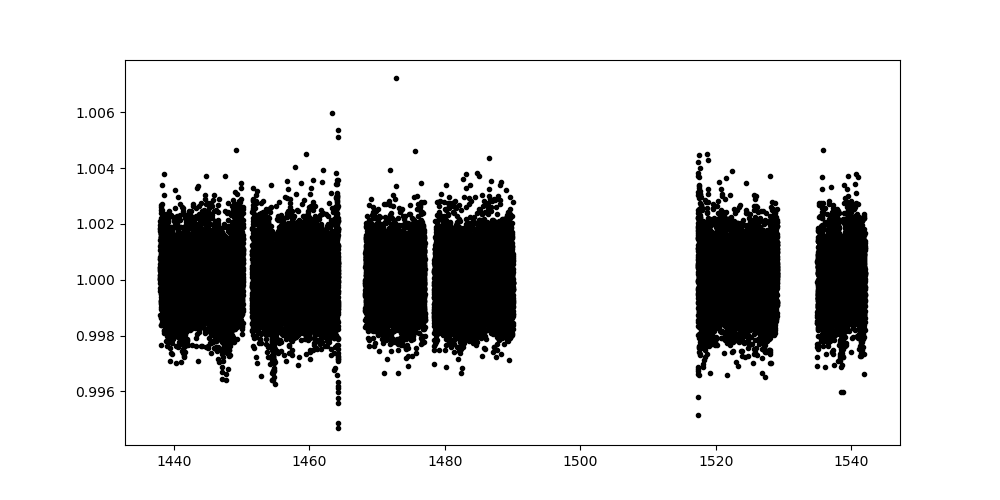

In [36]:
# plot the lightcurve 
# inspect this lighcurve to identity the time of the transit event(s) if you don't already know them
fig, axes = plt.subplots(figsize=(10,5))
plt.plot(alltime, allflux, '.k')
plt.show()

In [37]:
# enter the time(s) of all the events into this list 

transit_time_list = [1454.69, 1538.58]


<IPython.core.display.Javascript object>


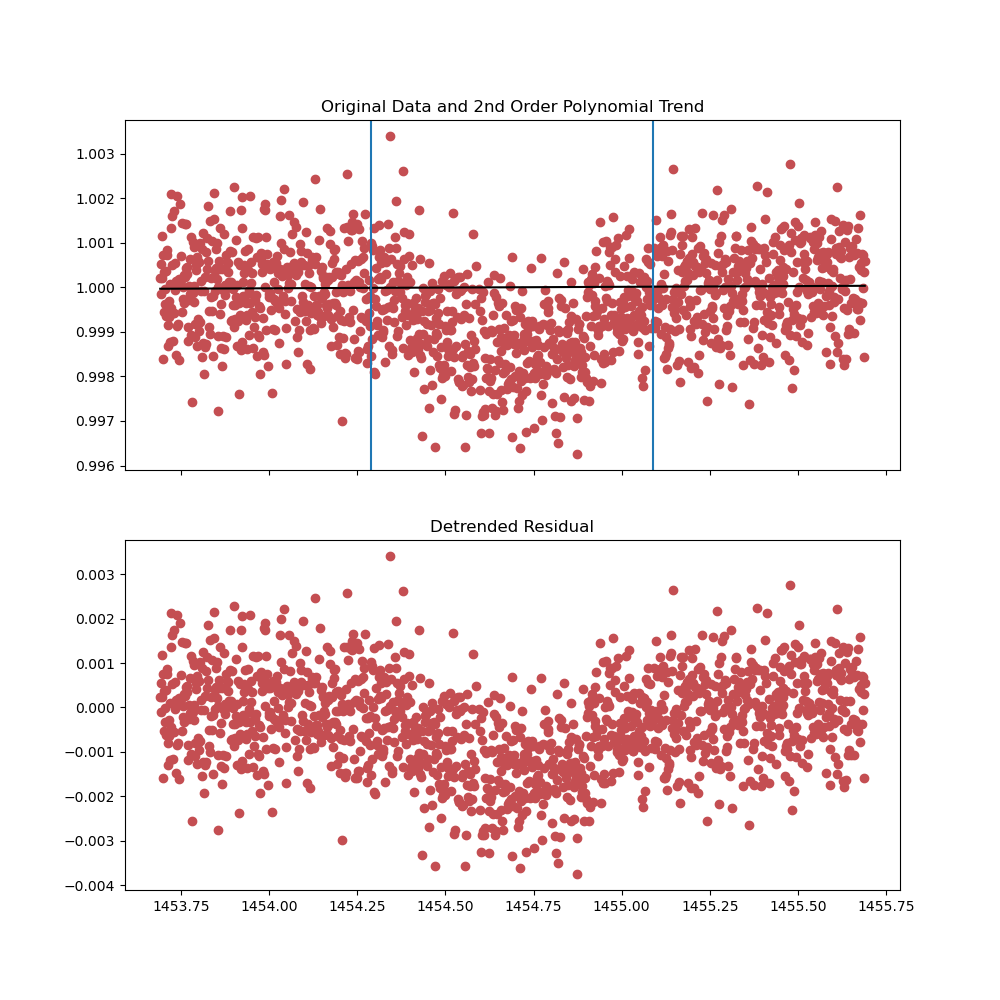

<IPython.core.display.Javascript object>


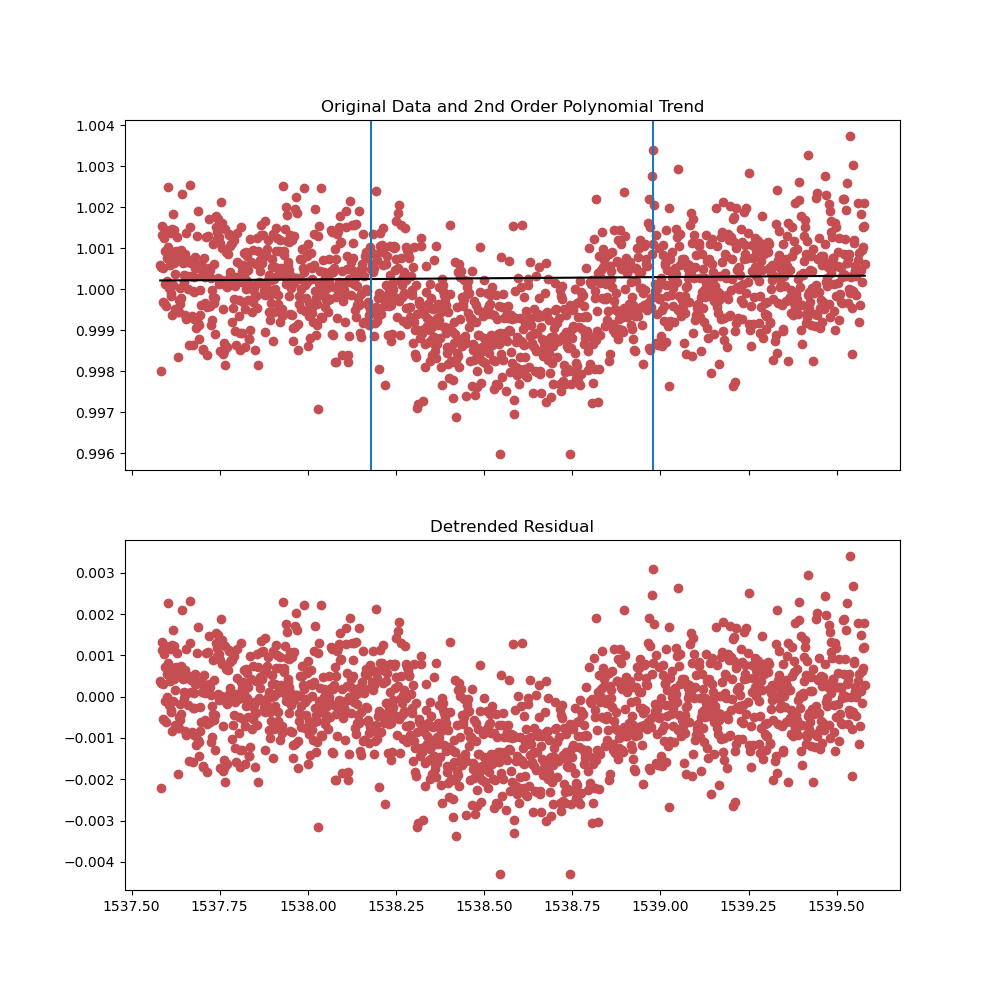

In [38]:
# to get a good fit you need to adjust these parameters

# the size of the cut-off window - ideally you want this to be a couple of times the transit duration
cutoutwindow_width = 1 

# this is to mask out the transit event (the stellar trend will be fit to the data excluding this data)
# this widnow is marked on by the blue vertical lines
transit_mask = 0.4

# this is the order of the polynomial - don't go to high! I recomment no higher than 3. 
polynomial_order = 1

detrend_pyaneti(tic, transit_time_list, alltime, allflux, allflux_err,cutoutwindow_width, transit_mask, polynomial_order, save = True)


# the second panel shows the detrended LC - check that it looks okay. The data is automatically saved and ready for pyaneti.